# **Ingénierie de données + Régression linéaire (Musées & population)**

Notre objectif est de construire un petit pipeline en Python pour récupérer automatiquement la liste des musées les plus visités (depuis Wikipédia), l'enrichir avec la population des villes (via le dataset depuis Kaggle), puis étudier la relation entre la population d'une ville et la fréquentation de ses musées à l'aide d'un modèle simple de régression linéaire.
Enfin, nous visualiserons le résultat de la régression pour interpréter la tendance.

## **Sommaire**

- **Récupération du tableau Wikipédia (scraping)**

- **Chargement et exploration du dataset des villes (population)**

- **Nettoyage et normalisation des données (noms de villes, formats numériques)**

- **Jointure musées ↔ villes (population)**

- **Analyse exploratoire & visualisations utiles**

- **Entraînement d'un modèle de régression linéaire**

- **Visualisation de la régression (nuage de points + droite)**

- **Conclusion : interprétation, limites et pistes d'amélioration**

## **Installation et importation des librairies**

Avant de commencer, nous devons exécuter la cellule ci-dessous afin de s'assurer que nous avons accès aux librairies nécessaires (scraping, manipulation de données, visualisation et ML).
On privilégie des outils simples, robustes et standard : **pandas** (data), **pandas.read_html** (Wikipédia), **matplotlib** (plots) et **scikit-learn** (régression).



In [522]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score




## **Récupération du tableau Wikipédia (scraping)**

In [523]:
# Scraping du tableau Wikipédia

url = "most-visited-museums.html"

tables = pd.read_html(url) #Récupère tous les tableaux de la page Wikipédia

df_museum = tables[0] #Sélectionne le premier tableau (le seul dans ce cas)



#df_museum.loc[2, "City"] = df_museum.loc[2, "City"].split(",")[-1].strip()

print(df_museum.head())



                       Name              Visitors                City  \
0                    Louvre  9,000,000 (2025) [1]               Paris   
1  National Museum of China   6,956,800 (2024)[2]             Beijing   
2           Vatican Museums   6,825,436 (2024)[3]  Vatican City, Rome   
3           Shenzhen Museum   6,805,000 (2024)[4]            Shenzhen   
4            British Museum   6,479,952 (2024)[5]              London   

          Country  
0          France  
1           China  
2         Vatican  
3           China  
4  United Kingdom  


## **Chargement et exploration du dataset des villes (population)**

In [524]:
# Chargement du dataset des villes

df_cities = pd.read_csv("world-largest-cities-by-population-2024.csv")

print(df_cities.head())

   Unnamed: 0       City     Country  Population (2024)  Population (2023)  \
0           0      Tokyo       Japan           37115035           37194105   
1           1      Delhi       India           33807403           32941309   
2           2   Shanghai       China           29867918           29210808   
3           3      Dhaka  Bangladesh           23935652           23209616   
4           4  Sao Paulo      Brazil           22806704           22619736   

   Growth Rate  
0      -0.0021  
1       0.0263  
2       0.0225  
3       0.0313  
4       0.0083  


## **Nettoyage et normalisation des données (noms de villes, formats numériques)**

In [525]:


#Suppression des colonnes inutiles : df_cities 
df_cities = df_cities.drop(columns=['Unnamed: 0','Population (2023)', 'Growth Rate' ])


print(df_cities.head())

        City     Country  Population (2024)
0      Tokyo       Japan           37115035
1      Delhi       India           33807403
2   Shanghai       China           29867918
3      Dhaka  Bangladesh           23935652
4  Sao Paulo      Brazil           22806704


In [526]:
#Normalisation de la colonne visitors : df_museum 
df_museum["Visitors"] = (
    df_museum["Visitors"]
    .str.replace(",", "", regex=False)
    .str.extract(r"(\d+)") #extrait les chiffres de la chaîne de caractères 
    .astype(int)
)



print("Colonnes de df_museum:\n",df_museum.dtypes,"\n")
print("Colonnes de df_cities:\n",df_cities.dtypes)

Colonnes de df_museum:
 Name          str
Visitors    int64
City          str
Country       str
dtype: object 

Colonnes de df_cities:
 City                   str
Country                str
Population (2024)    int64
dtype: object


In [527]:
#normalisation nom des villes : df_museum et rajout manuelle des villes manquantes 
df_museum["City"] = df_museum["City"].str.strip().str.lower()
df_cities["City"] = df_cities["City"].str.strip().str.lower()
ALIASES = {
    "london, south kensington": "london",
    "new york city": "new york",
    "washington, d.c.": "washington",
    "vatican city, rome": "rome"
} 
MANUAL_INSERT = {
    ("taichung", "taiwan"): 2867848,
    ("florence", "italy"): 382258,
    ("edinburgh", "united kingdom"): 537120,
    ("washington", "united states"): 6789720
}



def insert_missing_cities(df_cities, manual_insert):
    for (city, country), population in manual_insert.items():
            new_row = {"City": city, "Country": country, "Population (2024)": population}
            df_cities = pd.concat([df_cities, pd.DataFrame([new_row])], ignore_index=True)
    return df_cities

def normalize_city_names(df_museum, aliases):
    df_museum["City"] = df_museum["City"].replace(aliases)
    return df_museum

df_museum = normalize_city_names(df_museum, ALIASES)
df_cities = insert_missing_cities(df_cities, MANUAL_INSERT)

#print(df_museum[df_museum["City"].isin(["london", "new york", "washington", "rome"])])
print("------------------------------------------")
print(df_cities[df_cities["City"].isin(["florence", "edinburgh", "taichung", ])])
print("------------------------------------------")
#on garde uniquement les musées avec plus de 2000000 visiteurs 
df_museum = df_museum[df_museum["Visitors"] > 2000000]

#print(df_museum)
    


------------------------------------------
          City         Country  Population (2024)
801   taichung          taiwan            2867848
802   florence           italy             382258
803  edinburgh  united kingdom             537120
------------------------------------------


## **Jointure musées ↔ villes (population)**

In [528]:
# Jointure des données



df_joined = pd.merge(df_museum, df_cities[["City", "Population (2024)"]], on="City", how="left") 

#print(df_joined.head())

# print(df_joined.dtypes) 

print("Es ce qu'on a des valeurs nulles ?\n",df_joined.isnull().any(axis=1).sum()) 

print(df_joined.loc[df_joined.isnull().any(axis=1), ["City", "Population (2024)"]])


Es ce qu'on a des valeurs nulles ?
 0
Empty DataFrame
Columns: [City, Population (2024)]
Index: []


## **Analyse exploratoire & visualisations utiles**

/var/folders/5f/s1pv6spn5hv0ymdd_6zy0dqr0000gn/T/ipykernel_28824/931961955.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[2, 2, 0.5, 0.5])                    # Ajuste les marges


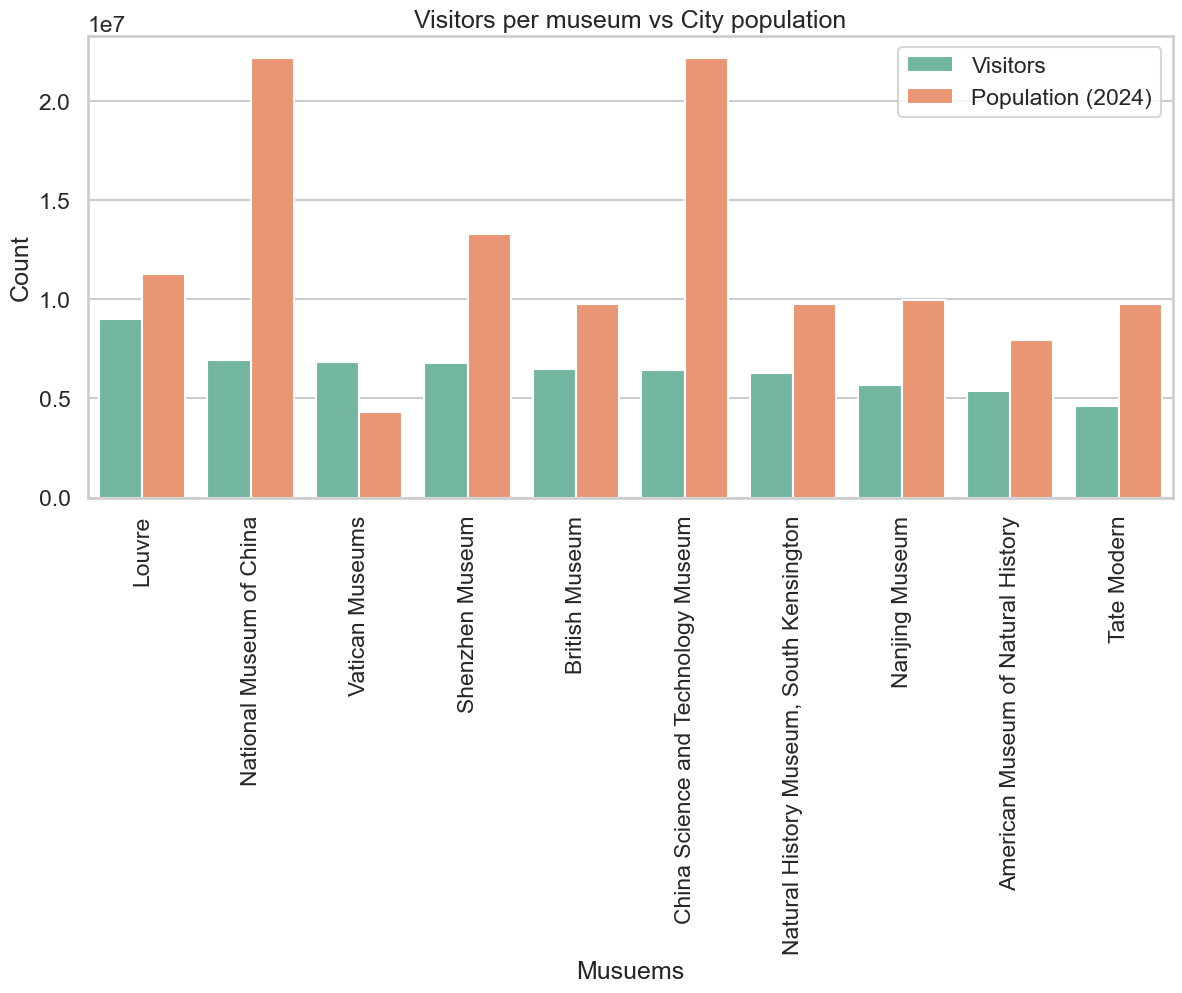

In [529]:
# Analyse exploratoire 

df_plot = df_joined.copy()              # Copie du DataFrame complet
df_plot = df_plot.sort_values("Visitors", ascending=False).head(10)  # Trie par visiteurs et garde les 10 premiers

df_melt = df_plot.melt(                # Transforme le DataFrame en format "long" pour seaborn
    id_vars="Name",                    # Colonne qui reste fixe (nom du musée)
    value_vars=["Visitors", "Population (2024)"],  # Colonnes à comparer
    var_name="Metric",                 # Nom de la colonne qui indiquera la métrique
    value_name="Value"                 # Nom de la colonne qui contiendra les valeurs
)

plt.figure(figsize=(14, 6))             # Crée une figure
ax = sns.barplot(data=df_melt, x="Name", y="Value", hue="Metric")  # Bar chart groupé
#ax.set_xscale("log")
plt.xticks(rotation=90)                # Rotation des labels de l’axe X
plt.xlabel("Musuems")                    # Label de l’axe X
plt.ylabel("Count")                    # Label de l’axe Y
plt.title("Visitors per museum vs City population")  # Titre du graphique
plt.legend(title="")                   # Légende
plt.tight_layout(rect=[2, 2, 0.5, 0.5])                    # Ajuste les marges
plt.show() 

## **Entraînement d'un modèle de régression linéaire**

In [530]:
# Entraînement du modèle
X = df_joined[["Population (2024)"]]
y = df_joined["Visitors"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficient (pente):", model.coef_[0])
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Coefficient (pente): 0.02254599887761552
MSE: 2470061191965.706
R²: 0.028646524310435018


## **Visualisation de la régression (nuage de points + droite)**

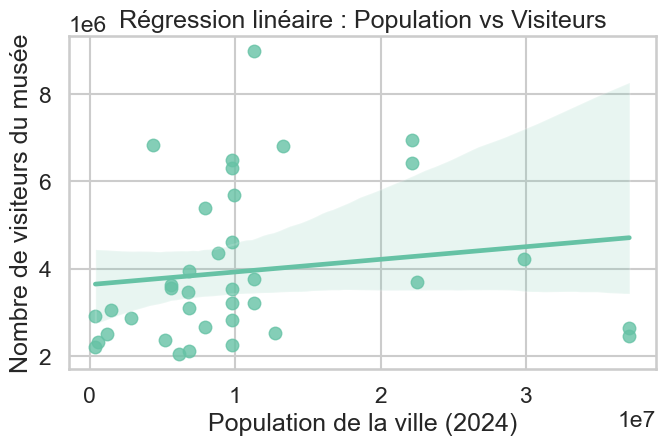

In [ ]:
# Visualisation de la régression

sns.set_theme(style="whitegrid", palette="Set2", context="talk")

plt.figure(figsize=(7, 5))
sns.regplot(data=df_joined, x="Population (2024)", y="Visitors", scatter=True)

plt.title("Régression linéaire : Population vs Visiteurs")
plt.xlabel("Population de la ville (2024)")
plt.ylabel("Nombre de visiteurs du musée")
plt.tight_layout()
plt.show()

## **Conclusion : interprétation, limites et pistes d'amélioration**

Le modèle de régression linéaire entraîné pour prédire le nombre de visiteurs à partir de la population de la ville présente une pente faible (coefficient ≈ **0.0225**), indiquant que l'augmentation de la population a un effet limité sur la fréquentation des musées.
Le score R² ≈ **0.0286** montre que la population n'explique qu'une faible proportion de la variance du nombre de visiteurs.
De plus, l'erreur quadratique moyenne (MSE ≈ **2.470 × 10¹²**) reste élevée, ce qui confirme que le modèle est peu précis pour la prédiction.
Ces résultats confirment que la taille de la ville, prise seule, est un mauvais prédicteur de l’affluence des musées.


D'autres indicateurs comme l'ancienneté du musée, sa réputation internationale, la qualité des collections, les événements culturels organisés ou la proximité de sites touristiques majeurs pourraient exercer une influence bien plus significative sur le nombre de visiteurs.